In [27]:
# cd PATH 

In [2]:
#IMPORT LIBS AND DEFINE CONSTANTS (img_shape)
import OpenEXR, Imath, numpy
pt = Imath.PixelType(Imath.PixelType.HALF) #pixel type
dtype = numpy.float16
golden = OpenEXR.InputFile("./Saved_low_Model/all/SavedRenderTexture1_1_Regular_5.exr")
dw = golden.header()['dataWindow']
print(golden.header())
img_shape = (dw.max.x - dw.min.x + 1, dw.max.y - dw.min.y + 1)

{'channels': {'A': HALF (1, 1), 'B': HALF (1, 1), 'G': HALF (1, 1), 'R': HALF (1, 1)}, 'compression': ZIP_COMPRESSION, 'dataWindow': (0, 0) - (255, 127), 'displayWindow': (0, 0) - (255, 127), 'lineOrder': INCREASING_Y, 'pixelAspectRatio': 1.0, 'screenWindowCenter': (0.0, 0.0), 'screenWindowWidth': 256.0}


In [8]:
half_chan = Imath.Channel(Imath.PixelType(Imath.PixelType.HALF))
header_in = OpenEXR.Header(256,128)
header_in['channels'] = dict([(c, half_chan) for c in "RGBDL"])
header_out = OpenEXR.Header(256,128)
header_out['channels'] = dict([(c, half_chan) for c in "RGB"])
def save_to_exr(data, is_X, file):
    if (is_X):
        #X
        exr = OpenEXR.OutputFile(file, header_in)
        exr.writePixels({'R': data[:, :, 0].tobytes(), 'G': data[:, :, 1].tobytes(), 'B': data[:, :, 2].tobytes(),
                         'D': data[:, :, 3].tobytes(), 'L': data[:, :, 4].tobytes()})
        exr.close()
    else:
        #y
        exr = OpenEXR.OutputFile(file, header_out)
        exr.writePixels({'R': data[:, :, 0].tobytes(), 'G': data[:, :, 1].tobytes(), 'B': data[:, :, 2].tobytes()})
        exr.close() 

In [28]:
#one image input: 
def get_one_input_image(number_obj, number_scene): 
    path = "./Saved_low_Model/all/SavedRenderTexture" + str(number_obj) + "_" + str(number_scene) + "_";
    
    path_spec = path + "Regular_5.exr";
    input_img = OpenEXR.InputFile(path_spec)
    (col_r, col_g, col_b) = input_img.channels("RGB", pt)
    red = numpy.frombuffer(col_r, dtype)
    green = numpy.frombuffer(col_g, dtype)
    blue = numpy.frombuffer(col_b, dtype)
    red.shape = (img_shape[1], img_shape[0])
    green.shape = (img_shape[1], img_shape[0])
    blue.shape = (img_shape[1], img_shape[0])
    
    path_spec = path + "Depth_.exr";
    input_img = OpenEXR.InputFile(path_spec)
    dep = input_img.channel('R', pt)
    depth = numpy.frombuffer(dep, dtype)
    depth.shape = (img_shape[1], img_shape[0])
    
    image_numpy = numpy.stack((red, green, blue, depth))
    return numpy.moveaxis(image_numpy, 0, -1).astype(dtype)
    # return numpy.expand_dims(numpy.moveaxis(image_numpy, 0, -1), axis=0) 

In [29]:
#one image output: 
def get_one_output_image(number_obj, number_scene, light_pos): 
    path = "./Saved_low_Model/all/SavedRenderTexture" + str(number_obj) + "_" + str(number_scene) + "_Regular_";

    path_spec = path + str(light_pos) + ".exr";
    input_img = OpenEXR.InputFile(path_spec)
    (col_r, col_g, col_b) = input_img.channels("RGB", pt)
    red = numpy.frombuffer(col_r, dtype)
    green = numpy.frombuffer(col_g, dtype)
    blue = numpy.frombuffer(col_b, dtype)
    red.shape = (img_shape[1], img_shape[0])
    green.shape = (img_shape[1], img_shape[0])
    blue.shape = (img_shape[1], img_shape[0])
    
    image_numpy = numpy.stack((red, green, blue))
    return numpy.moveaxis(image_numpy, 0, -1).astype(dtype)
    # return numpy.expand_dims(numpy.moveaxis(image_numpy, 0, -1), axis=0) 

In [30]:
#SAVE EXR TO EXR

number_of_batches = 91
batch_size = 120
max_batch_per_obj = 1
obj_counter = 1
scene_counter = 1
batch_counter = 0
iterat = 1
light_pos = 0

image = get_one_input_image(obj_counter, scene_counter)
# mark with class
my_label = numpy.full((128, 256, 1), light_pos)
print(image.shape)
print(my_label.shape)
marked_image = numpy.concatenate((image, my_label), axis = -1);
print(marked_image.shape)
image_out = get_one_output_image(obj_counter, scene_counter, light_pos) 
print(image_out.shape)

for i in range(1, number_of_batches + 1): #91 batch
    for j in range(1, batch_size + 1):
        image = get_one_input_image(obj_counter, scene_counter)
        for lig in range(0, 5):
            # mark with class
            my_label = numpy.full((128, 256, 1), lig).astype(dtype)
            marked_image = numpy.concatenate((image, my_label), axis = -1)
            save_to_exr(marked_image, True, "./Saved_low_Model_Depth/EXRInput/" + str(iterat) + ".exr")     
            image_out = get_one_output_image(obj_counter, scene_counter, lig) 
            save_to_exr(image_out, False, "./Saved_low_Model_Depth/EXROutput/" + str(iterat) + ".exr")
            iterat += 1
        scene_counter += 1
    batch_counter += 1
    if (batch_counter == max_batch_per_obj):
        obj_counter += 1
        batch_counter = 0
        max_batch_per_obj += 1
        scene_counter = 1


(128, 256, 4)
(128, 256, 1)
(128, 256, 5)
(128, 256, 3)


(128, 256, 3)


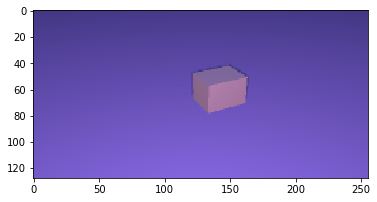

(128, 256, 3)


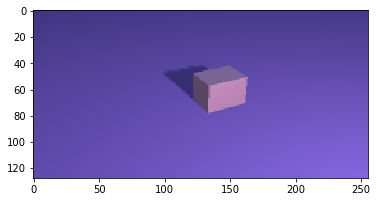

(128, 256, 3)


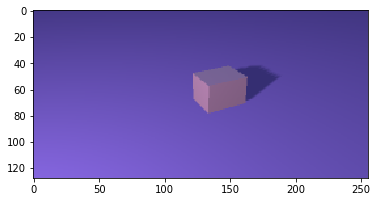

(128, 256, 3)


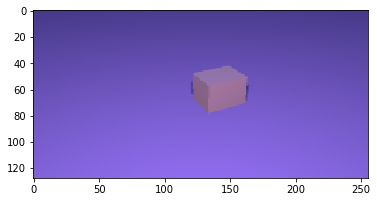

(128, 256, 3)


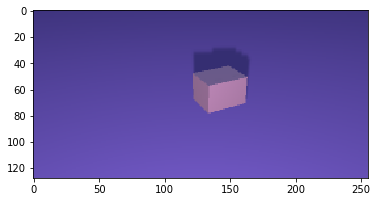

In [26]:
#GET OUTPUT IMAGE

for light in range(0, 5):
    img = get_one_output_image(1, 12, light)
    print(img.shape)
    from matplotlib import pyplot as plt
    plt.imshow(img[:, :, :].astype(numpy.float32), interpolation='nearest')
    plt.show()